## Analisis de la Encuesta Continua de Hogares 2024

- Dataset: https://www4.ine.gub.uy/Anda5/index.php/catalog/767/get-microdata
- Diccionario: https://www4.ine.gub.uy/Anda5/index.php/catalog/767/data-dictionary/F4?file_name=ECH_implantacion_2024

## Comienza el notebook de los modelos de combinacion lineal blending y stacking.

## Carga del dataset depurado

In [1]:
# IMPORTAMOS LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargar datasets limpios
X = pd.read_csv(r'D:\ut603933\Tesis-MCD\data_processed\X_clean.csv')
y = pd.read_csv(r'D:\ut603933\Tesis-MCD\data_processed\y_clean.csv').squeeze()  # .squeeze() para que sea Serie y no DataFrame

print("Shapes cargados:")
print("X:", X.shape)
print("y:", y.shape)

Shapes cargados:
X: (55923, 2846)
y: (55923,)


## Entrenamiento

In [3]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shapes tras split:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

Shapes tras split:
X_train: (44738, 2846)
X_test: (11185, 2846)


Conservamos la funcion para evaluar los diferentes modelos con metricas en train y en test.

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluar_modelo(modelo, X_train, y_train, X_test, y_test, nombre="modelo"):
    print("🟢 Entrenando modelo...")
    modelo.fit(X_train, y_train)

    print("🟢 Generando predicciones...")
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    print("🔍 Verificando predicciones...")
    print(f"Máximo y_pred_test: {np.max(y_pred_test)}")
    print(f"Mínimo y_pred_test: {np.min(y_pred_test)}")

    # ========= MÉTRICAS EN ESCALA LOG =========
    print("📊 Calculando métricas en escala log...")

    # --- Train ---
    r2_train = r2_score(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

    # --- Test ---
    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # ========= MÉTRICAS EN ESCALA ORIGINAL (PESOS) =========
    # Clip para evitar overflow al hacer exp()
    y_train_clip = np.clip(y_train, 0, 30)
    y_pred_train_clip = np.clip(y_pred_train, 0, 30)
    y_test_clip = np.clip(y_test, 0, 30)
    y_pred_test_clip = np.clip(y_pred_test, 0, 30)

    y_train_original = np.exp(y_train_clip)
    y_pred_train_original = np.exp(y_pred_train_clip)
    y_test_original = np.exp(y_test_clip)
    y_pred_test_original = np.exp(y_pred_test_clip)

    print(f"Máximo y_pred_original (clipped test): {np.max(y_pred_test_original)}")

    # --- Train pesos ---
    mae_train_pesos = mean_absolute_error(y_train_original, y_pred_train_original)
    rmse_train_pesos = np.sqrt(mean_squared_error(y_train_original, y_pred_train_original))

    # --- Test pesos ---
    mae_test_pesos = mean_absolute_error(y_test_original, y_pred_test_original)
    rmse_test_pesos = np.sqrt(mean_squared_error(y_test_original, y_pred_test_original))

    # ========= OUTPUT =========
    print("✅ Métricas finales:")
    print(f"Modelo: {nombre}")

    print(f"[Train] R2: {r2_train:.4f} | MAE_log: {mae_train:.2f} | RMSE_log: {rmse_train:.2f}")
    print(f"[Train] MAE_pesos: {mae_train_pesos:.2f} | RMSE_pesos: {rmse_train_pesos:.2f}")

    print(f"[Test]  R2: {r2_test:.4f} | MAE_log: {mae_test:.2f} | RMSE_log: {rmse_test:.2f}")
    print(f"[Test]  MAE_pesos: {mae_test_pesos:.2f} | RMSE_pesos: {rmse_test_pesos:.2f}")

    return {
        "modelo": nombre,
        "R2_train": r2_train,
        "MAE_log_train": mae_train,
        "RMSE_log_train": rmse_train,
        "MAE_pesos_train": mae_train_pesos,
        "RMSE_pesos_train": rmse_train_pesos,
        "R2_test": r2_test,
        "MAE_log_test": mae_test,
        "RMSE_log_test": rmse_test,
        "MAE_pesos_test": mae_test_pesos,
        "RMSE_pesos_test": rmse_test_pesos
    }

In [5]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Mejores modelos de Random Forest y xgboost

In [7]:
# Definir hiperparámetros y RandomizedSearchCV para Random Forest
param_rf = {
    "n_estimators": [200, 400, 600],
    "max_depth": [10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
search_rf = RandomizedSearchCV(rf, param_rf, n_iter=10, cv=3, scoring="r2",
                               random_state=42, n_jobs=-1, verbose=2)
search_rf.fit(X_train, y_train)
best_rf = search_rf.best_estimator_
print("✅ Mejor Random Forest:", search_rf.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Mejor Random Forest: {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}


In [8]:
# Definir hiperparámetros y RandomizedSearchCV para xgboost
param_xgb = {
    "n_estimators": [200, 400, 600],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}
xgb = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1)
search_xgb = RandomizedSearchCV(xgb, param_xgb, n_iter=10, cv=3, scoring="r2",
                                random_state=42, n_jobs=-1, verbose=2)
search_xgb.fit(X_train, y_train)
best_xgb = search_xgb.best_estimator_
print("✅ Mejor XGBoost:", search_xgb.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Mejor XGBoost: {'subsample': 0.8, 'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [9]:
# Evaluar modelos optimizados
res_rf = evaluar_modelo(best_rf, X_train, y_train, X_test, y_test, nombre="Random Forest Optimizado")
res_xgb = evaluar_modelo(best_xgb, X_train, y_train, X_test, y_test, nombre="XGBoost Optimizado")

🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 13.951850895584109
Mínimo y_pred_test: 2.8854443878509044
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1146071.8786031357
✅ Métricas finales:
Modelo: Random Forest Optimizado
[Train] R2: 0.9882 | MAE_log: 0.04 | RMSE_log: 0.07
[Train] MAE_pesos: 5031.06 | RMSE_pesos: 17581.47
[Test]  R2: 0.9367 | MAE_log: 0.10 | RMSE_log: 0.17
[Test]  MAE_pesos: 11813.12 | RMSE_pesos: 34596.79
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.895726203918457
Mínimo y_pred_test: 2.91107439994812
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 2945314.75
✅ Métricas finales:
Modelo: XGBoost Optimizado
[Train] R2: 0.9511 | MAE_log: 0.11 | RMSE_log: 0.15
[Train] MAE_pesos: 12755.46 | RMSE_pesos: 22632.87
[Test]  R2: 0.9154 | MAE_log: 0.14 | RMSE_log: 0.19
[Test]  MAE_pesos: 16259.64 | RMSE_pes

🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 13.951850895584109
Mínimo y_pred_test: 2.8854443878509044
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1146071.8786031357
✅ Métricas finales:
Modelo: Random Forest Optimizado
[Train] R2: 0.9882 | MAE_log: 0.04 | RMSE_log: 0.07
[Train] MAE_pesos: 5031.06 | RMSE_pesos: 17581.47
[Test]  R2: 0.9367 | MAE_log: 0.10 | RMSE_log: 0.17
[Test]  MAE_pesos: 11813.12 | RMSE_pesos: 34596.79
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.895726203918457
Mínimo y_pred_test: 2.91107439994812
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 2945314.75
✅ Métricas finales:
Modelo: XGBoost Optimizado
[Train] R2: 0.9511 | MAE_log: 0.11 | RMSE_log: 0.15
[Train] MAE_pesos: 12755.46 | RMSE_pesos: 22632.87
[Test]  R2: 0.9154 | MAE_log: 0.14 | RMSE_log: 0.19
[Test]  MAE_pesos: 16259.64 | RMSE_pesos: 36975.82

## Modelo Blending (promedio simple)

Blending no es un modelo en sí mismo de scikit-learn sino que es el promedio de predicciones de dos modelos ya entrenados. Por eso no se puede pasar directamente la funcion a evaluar_modelo. Por lo tanto, envolvemos ese promedio dentro de un modelo personalizado compatible con scikit-learn, creando una clase que implemente .fit() y .predict(). Así podemos evaluar el blending exactamente igual que los demás con tu función evaluar_modelo.

In [10]:
from sklearn.base import BaseEstimator, RegressorMixin

# Clase para Blending
class BlendingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, modelos):
        self.modelos = modelos

    def fit(self, X, y):
        # Entrenamos cada modelo
        for modelo in self.modelos:
            modelo.fit(X, y)
        return self

    def predict(self, X):
        # Promediamos las predicciones
        preds = np.column_stack([modelo.predict(X) for modelo in self.modelos])
        return np.mean(preds, axis=1)

In [11]:
# Blending (promedio simple)
print("\n🟢 Evaluando Blending (RF + XGB)...")
blend_model = BlendingRegressor(modelos=[best_rf, best_xgb])
res_blend = evaluar_modelo(blend_model, X_train, y_train, X_test, y_test, nombre="Blending (RF+XGB)")


🟢 Evaluando Blending (RF + XGB)...
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.423788549751283
Mínimo y_pred_test: 2.8982593938995125
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1837264.8879587846
✅ Métricas finales:
Modelo: Blending (RF+XGB)
[Train] R2: 0.9768 | MAE_log: 0.07 | RMSE_log: 0.10
[Train] MAE_pesos: 8612.80 | RMSE_pesos: 18536.90
[Test]  R2: 0.9340 | MAE_log: 0.11 | RMSE_log: 0.17
[Test]  MAE_pesos: 13433.24 | RMSE_pesos: 33578.28


🟢 Evaluando Blending (RF + XGB)...
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.423788549751283
Mínimo y_pred_test: 2.898259393899512
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1837264.8879587846
✅ Métricas finales:
Modelo: Blending (RF+XGB)
[Train] R2: 0.9768 | MAE_log: 0.07 | RMSE_log: 0.10
[Train] MAE_pesos: 8612.80 | RMSE_pesos: 18536.90
[Test]  R2: 0.9340 | MAE_log: 0.11 | RMSE_log: 0.17
[Test]  MAE_pesos: 13433.24 | RMSE_pesos: 33578.28

## Modelo Stacking (RF + XGB -> LinearRegression)

In [12]:
# Stacking (RF + XGB -> LinearRegression)
print("\n🟢 Evaluando Stacking (RF + XGB -> LR)...")
stacking_model = StackingRegressor(
    estimators=[("RF", best_rf), ("XGB", best_xgb)],
    final_estimator=LinearRegression(),
    cv=3, n_jobs=-1
)

res_stacking = evaluar_modelo(stacking_model, X_train, y_train, X_test, y_test, nombre="Stacking RF+XGB -> LR")



🟢 Evaluando Stacking (RF + XGB -> LR)...
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.312100191016981
Mínimo y_pred_test: 2.557745822606508
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1643108.1030942453
✅ Métricas finales:
Modelo: Stacking RF+XGB -> LR
[Train] R2: 0.9849 | MAE_log: 0.06 | RMSE_log: 0.08
[Train] MAE_pesos: 6704.26 | RMSE_pesos: 15509.65
[Test]  R2: 0.9377 | MAE_log: 0.10 | RMSE_log: 0.17
[Test]  MAE_pesos: 12377.27 | RMSE_pesos: 32303.25


🟢 Evaluando Stacking (RF + XGB -> LR)...
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.312100191016981
Mínimo y_pred_test: 2.557745822606508
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1643108.1030942453
✅ Métricas finales:
Modelo: Stacking RF+XGB -> LR
[Train] R2: 0.9849 | MAE_log: 0.06 | RMSE_log: 0.08
[Train] MAE_pesos: 6704.26 | RMSE_pesos: 15509.65
[Test]  R2: 0.9377 | MAE_log: 0.10 | RMSE_log: 0.17
[Test]  MAE_pesos: 12377.27 | RMSE_pesos: 32303.25

## Comparacion de resultados

In [13]:
# Comparativa final
df_resultados = pd.DataFrame([res_rf, res_xgb, res_blend, res_stacking])
print("\n📊 Comparativa de modelos (Optimización + Ensemblings):")
print(df_resultados)


📊 Comparativa de modelos (Optimización + Ensemblings):
                     modelo  R2_train  MAE_log_train  RMSE_log_train  \
0  Random Forest Optimizado  0.988210       0.039193        0.074590   
1        XGBoost Optimizado  0.951129       0.114570        0.151859   
2         Blending (RF+XGB)  0.976805       0.074412        0.104619   
3     Stacking RF+XGB -> LR  0.984924       0.057073        0.084344   

   MAE_pesos_train  RMSE_pesos_train   R2_test  MAE_log_test  RMSE_log_test  \
0      5031.060495      17581.469757  0.936717      0.095320       0.168195   
1     12755.464407      22632.868165  0.915410      0.138801       0.194459   
2      8612.797405      18536.900473  0.934009      0.112234       0.171756   
3      6704.256165      15509.650507  0.937744      0.103123       0.166825   

   MAE_pesos_test  RMSE_pesos_test  
0    11813.118758     34596.788107  
1    16259.640911     36975.824651  
2    13433.237170     33578.275313  
3    12377.265874     32303.251363  


📊 Comparativa de modelos (Optimización + Ensemblings):
                     modelo  R2_train  MAE_log_train  RMSE_log_train  \
0  Random Forest Optimizado  0.988210       0.039193        0.074590   
1        XGBoost Optimizado  0.951129       0.114570        0.151859   
2         Blending (RF+XGB)  0.976805       0.074412        0.104619   
3     Stacking RF+XGB -> LR  0.984924       0.057073        0.084344   

   MAE_pesos_train  RMSE_pesos_train   R2_test  MAE_log_test  RMSE_log_test  \
0      5031.060495      17581.469757  0.936717      0.095320       0.168195   
1     12755.464407      22632.868165  0.915410      0.138801       0.194459   
2      8612.797405      18536.900473  0.934009      0.112234       0.171756   
3      6704.256165      15509.650507  0.937744      0.103123       0.166825   

   MAE_pesos_test  RMSE_pesos_test  
0    11813.118758     34596.788107  
1    16259.640911     36975.824651  
2    13433.237170     33578.275313  
3    12377.265874     32303.251363|

🔎 Importancia de variables - Stacking


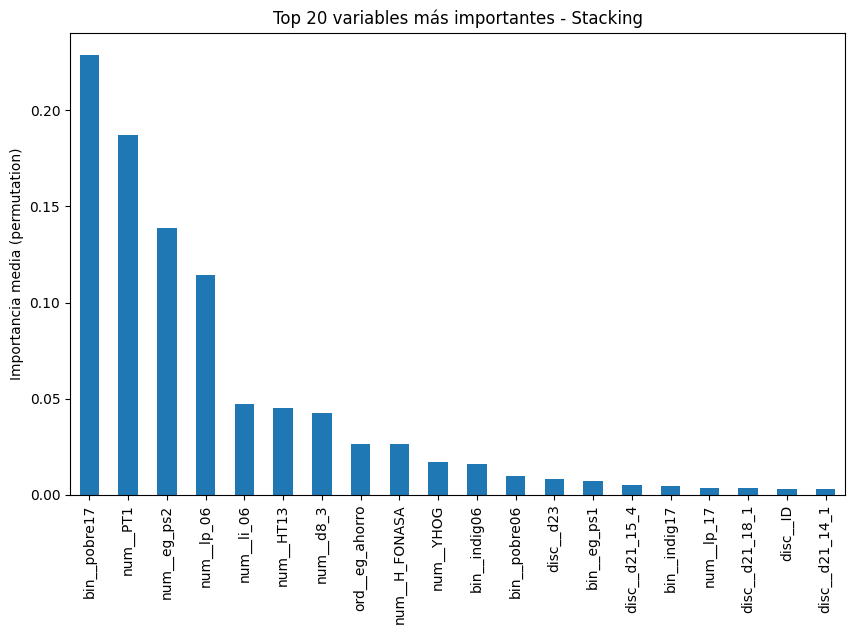

In [15]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- STACKING ---
print("🔎 Importancia de variables - Stacking")
result_stacking = permutation_importance(stacking_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1)
importances_stacking = pd.Series(result_stacking.importances_mean, index=X_test.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances_stacking.head(20).plot(kind='bar')
plt.title("Top 20 variables más importantes - Stacking")
plt.ylabel("Importancia media (permutation)")
plt.show()